In [13]:
import numpy as np
#import matplotlib.pyplot as plt
import corner
import emcee
from invisoplanet_detection.statistics import *
import math

In [40]:
def run_MCMC(filepath, known_bodies, unknown_bodies, num_dim, surrogate_points = 9, num_iter_likelihood = 20000, 
             max_mass_factor = 100, time_step = 0.5, last_n = 100, eta = 1, num_walker = 16, num_iter_MCMC = 5000, 
             init_guess_factor_1 = 2, init_guess_factor_2 = 2, discard = 500, thin = 10):
    
    """
    PARAMETERS
    
    - filepath: path to file containing the masses, initial positions and initial velocities of the bodies for the N-body 
                simulation
    - known_bodies: number of known bodies in the system (N)
    - unknown_bodies: number of unknown bodies in the system (m)
    - num_dim: dimensionality of the MCMC algorithm (number of parameters)
    - surrogate_points: number of points for the surrogate model in the determination of the likelihood
    - num_iter_likelihood: number of iterations to run the simulation for the determination of the likelihood
    - max_mass_factor: factor by which to multiply the actual mass to define the maximal allowed mass
    - time_step: dt for the simulation for the determination of the likelihood
    - last_n: value from 0-100 representing the percentage of points at the end of the simulation to keep for the surrogate 
              model
    - eta: value to set eta when excluded from the MCMC parameters
    - num_walker: number of walker for the MCMC EnsembleSampler
    - num_iter_MCMC: number of iteration for which to run the MCMC algorithm
    - init_guess_factor_1 and _2: the initial position of the num_walker is determined with random number in [0,1) x actual
                                  mass of unknown body 1 or 2 x init_guess_factor 1 or 2, respectively
    - discard: first x points to discard from the MCMC algorithm
    - thin: factor by which to thin the points from the MCMC algorithm.
    
    """

    #Retrieve mass of unknown bodies:
    with open(filepath, "r") as file:
        ics = json.load(file)
    unknown_masses_list = []
    for i, body in enumerate(ics["bodies"]):
        if i >= known_bodies:
            mass = body["mass"]
            unknown_masses_list.append(mass)
    
    #Define max_masses from the unknown_masses_list:
    max_masses = np.array(unknown_masses_list, dtype = float) * max_mass_factor
    max_masses[max_masses == 0] = 0.001
    
    #Construct the likelihood:
    likelihood = Likelihood(known_bodies, unknown_bodies, filepath, max_masses, surrogate_points, num_iter_likelihood, 
                            time_step, last_n)

    #Define initial positions for the walkers for MCMC:
    if unknown_bodies == 1 and num_dim == 1: #Running MCMC for 1 unknown body
        array = np.array([[max_masses[0]/100*init_guess_factor_1]])
    elif unknown_bodies == 1 and num_dim == 2: #Running MCMC for 1 unknown body and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, 1]])
    elif unknown_bodies == 2 and num_dim == 2: #Running MCMC for 2 unknown bodies
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, max_masses[1]/100*init_guess_factor_2]])
    elif unknown_bodies == 2 and num_dim == 3: #Running MCMC for 2 unknown bodies and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0, 0],[0, max_masses[1]/100*init_guess_factor_2, 0],[0, 0, 1]])
    else:
        return likelihood.hardcoded_error_message()
    init_pos = np.random.rand(num_walker, num_dim) @ array + 0.5 * np.ones(num_walker, num_dim)
    
    #Run the MCMC
    if num_dim == unknown_bodies:
        likelihood.set_eta(eta)
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    else:
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior_variable_eta)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    
    return sampler.get_chain(), sampler.get_chain(discard = discard, thin = thin, flat = True)

In [35]:
#Running the three "toy model" systems to test the run-time and convergence of the MCMC.

#NOTE: planets and star denoted by CAPITAL LETTERS represent the KNOWN bodies in the system. Planets and star denoted in lower
#      case letters are the unknown bodies.

samples_SUN_JUP, flat_SUN_JUP = run_MCMC("invisoplanet_detection/data/sun_jup_2_0_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:17<00:00, 64.47it/s]


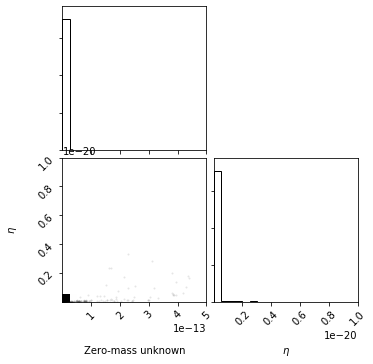

In [23]:
fig_SUN_JUP = corner.corner(flat_SUN_JUP, range = [(0, 5e-13), (0, 1e-20)], labels = ['Zero-mass unknown', r'$\eta$']);

In [38]:
samples_SUN_JUP_no_eta, flat_SUN_JUP_no_eta = run_MCMC("invisoplanet_detection/data/sun_jup_2_0_1.json", 2, 1, 1)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.19it/s]


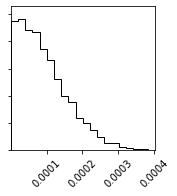

In [39]:
fig_SUN_JUP_no_eta = corner.corner(flat_SUN_JUP_no_eta)

In [42]:
samples_SUN_JUP_sat, flat_SUN_JUP_sat = run_MCMC("invisoplanet_detection/data/sun_jup_sat_2_1_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.78it/s]


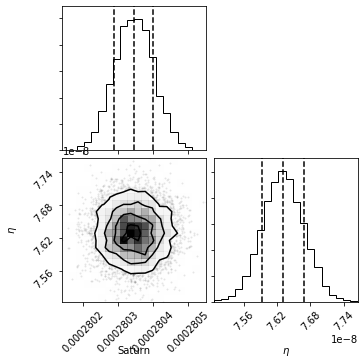

In [43]:
fig_SUN_JUP_sat = corner.corner(flat_SUN_JUP_sat, labels = ['Saturn', r'$\eta$'], quantiles=[0.16, 0.5, 0.84]);

In [17]:
samples_SAT_sun_jup, flat_SAT_sun_jup = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, 
                                                 init_guess_factor_1 = 50, init_guess_factor_2 = 50, num_iter_MCMC = 10000, 
                                                 num_iter_likelihood = 40000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:44<00:00, 29.06it/s]


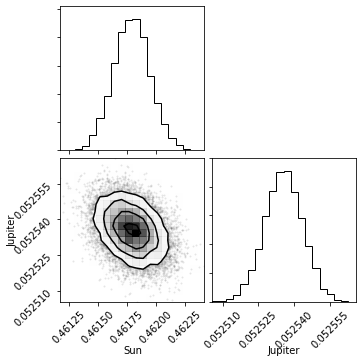

In [18]:
fig_SAT_sun_jup = corner.corner(flat_SAT_sun_jup, labels = ['Sun', 'Jupiter'])

In [3]:
#testing the influence of the initial position of the walker on the convergence of the 
samples_SAT_sun_jup_dif_IC, flat_SAT_sun_jup_dif_IC = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, 
                                                               init_guess_factor_1 = 50, init_guess_factor_2 = 1, 
                                                               num_iter_MCMC = 10000, num_iter_likelihood = 40000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:08<00:00, 53.19it/s]


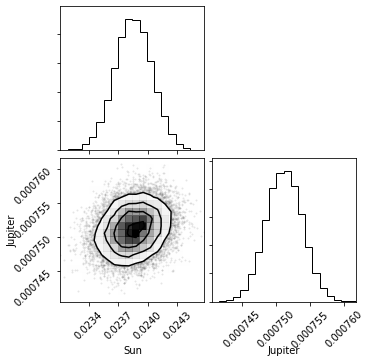

In [9]:
fig_SAT_sun_jup_dif_IC = corner.corner(flat_SAT_sun_jup_dif_IC, labels = ['Sun', 'Jupiter'])

In [6]:
samples_SAT_sun_jup_eta, flat_SAT_sun_jup_eta = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 3, 
                                                         num_iter_MCMC = 10000, num_iter_likelihood = 40000, 
                                                         init_guess_factor_1 = 50, init_guess_factor_2 = 50)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:05<00:00, 40.74it/s]


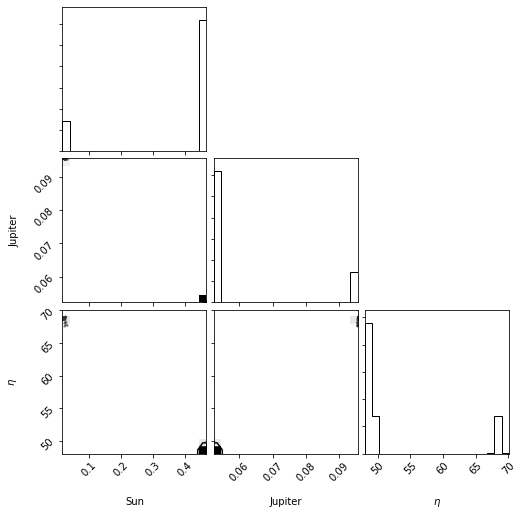

In [8]:
fig_SAT_sun_jup_eta = corner.corner(flat_SAT_sun_jup_eta, labels = ['Sun', 'Jupiter', r'$\eta$'])

In [3]:
#Going crazy with our systems and modelling the whole solar system!
samples_SOLAR_SYSTEM_sun, flat_SOLAR_SYSTEM_sun = run_MCMC("invisoplanet_detection/data/solar_system_8_1_1.json", 8, 1, 2, 
                                                           num_iter_likelihood = 100000, num_iter_MCMC = 30000)

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [5:36:04<00:00,  1.49it/s]


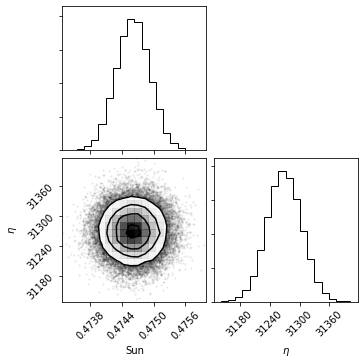

In [20]:
fig_SOLAR_SYSTEM_sun = corner.corner(flat_SOLAR_SYSTEM_sun, labels = ['Sun', r'$\eta$'])

In [ ]:
#Restricting the prior between 0.5 and 1.5 for the mass of the Sun.
samples_SOLAR_SYSTEM_sun_05_15, flat_SOLAR_SYSTEM_sun_05_15 = run_MCMC("invisoplanet_detection/data/solar_system_8_1_1.json", 
                                                                       8, 1, 2, num_iter_likelihood = 100000, 
                                                                       num_iter_MCMC = 30000, max_mass_factor = 1.5, 
                                                                       init_guess_factor_1 = 1)

In [4]:
#Testing the limits of the code:
samples_SOLAR_SYSTEM_pluto, flat_SOLAR_SYSTEM_pluto = run_MCMC("invisoplanet_detection/data/solar_system_pluto_9_1_1.json", 
                                                               9, 1, 2, num_iter_likelihood = 50000, num_iter_MCMC = 20000)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:08:12<00:00,  2.60it/s]


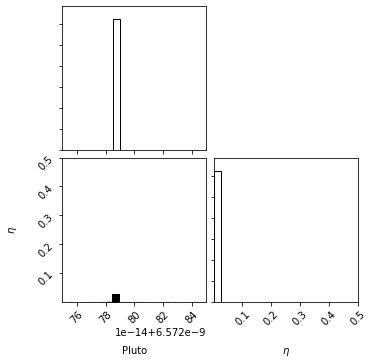

In [21]:
fig_SOLAR_SYSTEM_pluto = corner.corner(flat_SOLAR_SYSTEM_pluto, range = [(6.57275e-9,6.57285e-9),(0,0.5)], 
                                       labels = ['Pluto', r'$\eta$'])

In [8]:
samples_JUP_EUROPA_sun, flat_JUP_EUROPA_sun = run_MCMC("invisoplanet_detection/data/jup_jupmoon_sun_2_1_1.json", 2, 1, 2, 
                                                       num_iter_likelihood = 50000, num_iter_MCMC = 20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [34:32<00:00,  9.65it/s]


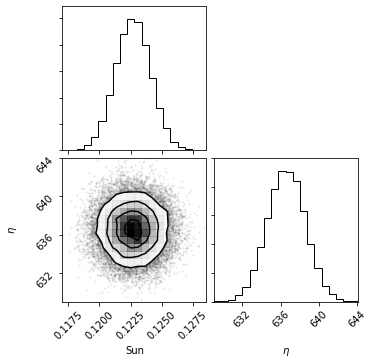

In [22]:
fig_JUP_EUROPA_sun = corner.corner(flat_JUP_EUROPA_sun, labels = ['Sun', r'$\eta$'])

In [11]:
#Running the MCMC with a similation that now has boundary conditions on the size of the system (100AU).
samples_SAT_sun_jup_bonded, flat_SAT_sun_jup_bonded = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, 
                                                               init_guess_factor_1 = 50, init_guess_factor_2 = 50)

Mass 2 list:   0%|                                                                               | 0/9 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.56it/s]


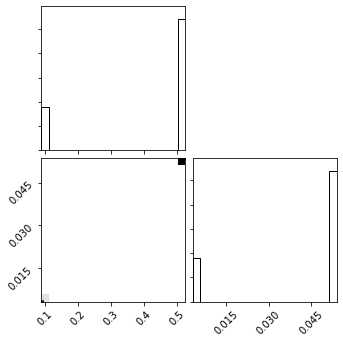

In [12]:
fig_SAT_sun_jup_bonded = corner.corner(flat_SAT_sun_jup_bonded)